In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image as PILImage
from IPython.display import display
import webcolors
from skimage import color
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
# to load yolo model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master
C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master\utils\general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5  2025-6-22 Python-3.9.1rc1 torch-2.6.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [3]:
# loading the image

img_path = 'input/test1.jpeg'
image = cv.imread(img_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

In [4]:
#running the yolo interference

results = model(image_rgb)

C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [5]:
# to convert to pandas df and filter for 'person' class

df = results.pandas().xyxy[0]
people = df[df['name'] == 'person']

In [6]:
# to draw bouding boxes

image_copy = image.copy()
for i,row in people.iterrows():
    x1,y1,x2,y2 = map(int, [row['xmin'],row['ymin'],row['xmax'],row['ymax']])
    cv.rectangle(image_copy, (x1,y1),(x2,y2), (0,255,0), 2)
    label = f'Person {i+1}'
    (tw, th), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv.rectangle(image_copy, (x1, y1 - th - 6), (x1 + tw, y1), (0, 255, 0), -1)
    cv.putText(image_copy, label, (x1, y1 - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    

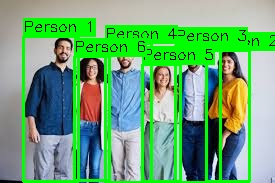

In [7]:
cv.imwrite("output/detected_people.jpg", image_copy)
display(PILImage.open("output/detected_people.jpg"))

In [8]:
os.makedirs("output/shirts_bb", exist_ok=True)
shirt_crops = []

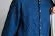

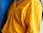

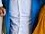

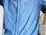

In [9]:
for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region (middle torso)
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 30:
        print(f"Crop size for person {idx+1}: {shirt_crop.shape}")

        continue

    filename = f"output/shirts_bb/shirt_{idx+1}.jpg"
    cv.imwrite(filename, cv.cvtColor(shirt_crop, cv.COLOR_RGB2BGR))
    shirt_crops.append((shirt_crop, filename))

    display(PILImage.open(filename))

In [10]:
from sklearn.cluster import KMeans
from collections import Counter

COMMON_COLORS = {
    "red": (200, 60, 60),
    "dark red": (139, 0, 0),
    "blue": (0, 102, 204),
    "light blue": (145, 184, 224),
    "sky blue": (135, 206, 235),
    "green": (60, 179, 113),
    "yellow": (255, 215, 0),
    "orange": (255, 140, 0),
    "purple": (138, 43, 226),
    "pink": (255, 182, 193),
    "white": (240, 240, 240),
    "black": (10, 10, 10),
    "gray": (128, 128, 128),
    "brown": (139, 69, 19),
}


def get_dominant_color(image, k=3):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    counts = Counter(kmeans.labels_)
    dominant = kmeans.cluster_centers_[counts.most_common(1)[0][0]]
    return tuple(map(int, dominant))


def classify_color_lab(rgb):
    """Classifies given RGB color to the closest color name using LAB distance."""
    rgb = np.array([[rgb]], dtype=np.uint8) / 255.0
    lab = color.rgb2lab(rgb)[0][0]

    min_dist = float("inf")
    closest_color = None

    for name, ref_rgb in COMMON_COLORS.items():
        ref_rgb_array = np.array([[ref_rgb]], dtype=np.uint8) / 255.0
        ref_lab = color.rgb2lab(ref_rgb_array)[0][0]
        dist = np.linalg.norm(lab - ref_lab)

        if dist < min_dist:
            min_dist = dist
            closest_color = name

    return closest_color





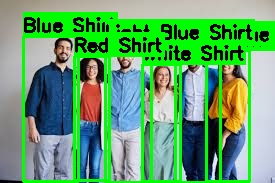

In [11]:
labeled_image = image.copy()

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # shirt crop 
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        print(f"Skipped: Crop too small for person {idx+1}")
        continue

    # dominant color
    dom_color = get_dominant_color(shirt_crop)
    color_name = classify_color_lab(dom_color)


    # bounding box
    cv.rectangle(labeled_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Label with person ID + color
    label = f'{color_name.title()} Shirt'  # 👈 better label
    (tw, th), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv.rectangle(labeled_image, (x1, y1 - th - 10), (x1 + tw, y1), (0, 255, 0), -1)
    cv.putText(labeled_image, label, (x1, y1 - 5),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)


# Save and display
cv.imwrite("output/labeled_with_colors.jpg", labeled_image)
display(PILImage.open("output/labeled_with_colors.jpg"))




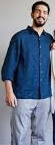

👤 Person 1 — Shirt Color Detected: BLUE (RGB: (31, 73, 121))


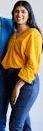

👤 Person 2 — Shirt Color Detected: BROWN (RGB: (169, 94, 12))


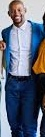

👤 Person 3 — Shirt Color Detected: LIGHT BLUE (RGB: (187, 194, 217))


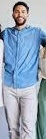

👤 Person 4 — Shirt Color Detected: LIGHT BLUE (RGB: (145, 184, 224))


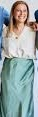

👤 Person 5 — Shirt Color Detected: WHITE (RGB: (219, 218, 217))


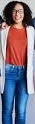

👤 Person 6 — Shirt Color Detected: RED (RGB: (196, 81, 69))


In [12]:
os.makedirs("output/people_cropped", exist_ok=True)

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region (mid-torso)
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        print(f"❌ Skipped person {idx+1}: Shirt crop too small.")
        continue

    # Dominant color & matched name
    dom_color = get_dominant_color(shirt_crop)
    color_name = classify_color_lab(dom_color)

    # Save cropped person image
    save_path = f"output/people_cropped/person_{idx+1}.jpg"
    cv.imwrite(save_path, cv.cvtColor(person_crop, cv.COLOR_RGB2BGR))
    display(PILImage.open(save_path))

    # Output label text in console
    print(f"👤 Person {idx+1} — Shirt Color Detected: {color_name.upper()} (RGB: {dom_color})")

In [13]:
from collections import defaultdict

# Step A1: Initialize grouping dict
color_groups = defaultdict(list)

# Step A2: Store each person ID in the detected color group
for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        continue

    dom_color = get_dominant_color(shirt_crop)
    color_name = classify_color_lab(dom_color)
    
    # Add this person to the group
    color_groups[color_name.title()].append(idx + 1)

# Step A3: Show grouped output
print("\n🎨 Shirt Color Groups:")
for color, person_ids in color_groups.items():
    emoji = "👕"
    print(f"{emoji} {color.upper():<10}: {len(person_ids)} person(s) → IDs {person_ids}")



🎨 Shirt Color Groups:
👕 BLUE      : 1 person(s) → IDs [1]
👕 BROWN     : 1 person(s) → IDs [2]
👕 LIGHT BLUE: 2 person(s) → IDs [3, 4]
👕 WHITE     : 1 person(s) → IDs [5]
👕 RED       : 1 person(s) → IDs [6]


In [14]:
import numpy as np
from skimage import color

rgb = (255, 0, 0)
rgb_array = np.array([[rgb]], dtype=np.uint8) / 255.0
lab = color.rgb2lab(rgb_array)[0][0]
print(lab)


[     53.241      80.092      67.203]


In [25]:
# 🎯 Option B: Filter People by User-Defined Shirt Color
target_color = input("Enter the shirt color to filter: ").strip().lower()

matched_ids = []

print(f"\n🎯 Filtering people by shirt color: {target_color.upper()}\n")

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        continue

    dom_color = get_dominant_color(shirt_crop)
    detected_color = classify_color_lab(dom_color)

    if detected_color.lower() == target_color.lower():
        matched_ids.append(idx + 1)
        # Display image
        print(f"✅ Person {idx+1} - {detected_color.upper()} Shirt")
        save_path = f"output/filtered/person_{idx+1}.jpg"
        os.makedirs("output/filtered", exist_ok=True)
        cv.imwrite(save_path, cv.cvtColor(person_crop, cv.COLOR_RGB2BGR))
        display(PILImage.open(save_path))

# Final summary
print("✅ Matches Found:", len(matched_ids))
print("👥 Matched Person IDs:", matched_ids if matched_ids else "❌ No matching people found.")


Enter the shirt color to filter:  black



🎯 Filtering people by shirt color: BLACK

✅ Matches Found: 0
👥 Matched Person IDs: ❌ No matching people found.
